In [1]:
import numpy as np
import pandas as pd
import csv
import math

In [2]:
def calc_sec(time):
    hms = time.split(':')
    hms = [float(x) for x in hms]
    sec = hms[2] + hms[1]*60 + hms[0]*3600
    sec = round(sec,3)
    return sec

In [3]:
def calc_ts(sec):
    ts = ''
    hr = int(sec/3600)
    mn = int((sec - (hr*3600))/60)
    sc = sec - (hr*3600) - (mn*60)
    sc = round(sc,3)
    ts += str(hr) + ':' + str(mn) + ':' + str(sc)
    # print(ts)
    return ts

In [4]:
filepath = 'SmartwatchData/prep_data/data_acc.csv'
df = pd.read_csv(filepath)
# print(df.head())

df_grp = df.groupby('date')

idx = {}
df_key = {}

for key,item in df_grp:
    idx[key] = df_grp.get_group(key).index
    df_key[key] = df_grp.get_group(key)

dates = list(df_key.keys())

In [5]:
key_list = ['time','x','y','z','label']
new_lines = []

# change from 160ms+-2ms to 1s
for d in dates:
    df_date = df.loc[df['date']==d]
    
    data_dict = {}
    
    for k in key_list:
        data_dict[k] = []
    
    for i in range(len(df_date)):
        for k in key_list:
            data_dict[k].append(df_date.iloc[i][k])
    
    prev_t = data_dict['time'][0]
    prev_sec = calc_sec(prev_t)
    
    exact_dur = 0.16

    trimmed_mean_list = []
    trimmed_mean_elem = []
    
    for i in range(len(data_dict['time'])):
        time = data_dict['time'][i]
        x = data_dict['x'][i]
        y = data_dict['y'][i]
        z = data_dict['z'][i]
        label = data_dict['label'][i]
        
        sec = calc_sec(time)

        duration = sec - prev_sec
        duration = round(duration,3)
        # print(duration)
        
        if(duration!=exact_dur and duration!=0.0 and duration<2*exact_dur):
            new_sec = prev_sec + exact_dur
        else:
            new_sec = prev_sec + duration
        
        diff_sec = math.floor(new_sec)-math.floor(prev_sec)
        
        if(diff_sec>=1):                           # If it's the first millisecond in timestamp
            trimmed_mean_np = np.array(trimmed_mean_list)
            # print(trimmed_mean_np)
            x_item = sorted([float(item[1]) for item in trimmed_mean_np])
            y_item = sorted([float(item[2]) for item in trimmed_mean_np])
            z_item = sorted([float(item[3]) for item in trimmed_mean_np])

            x_item = np.array(x_item[1:-1])         # Drop the min,max data in the list
            y_item = np.array(y_item[1:-1])
            z_item = np.array(z_item[1:-1])

            # print(math.floor(prev_sec))

            if(len(x_item)>0):
                x0 = round(np.mean(x_item),8)  # Calculate mean value on each axis
                y0 = round(np.mean(y_item),8)
                z0 = round(np.mean(z_item),8)
            else:
                x0 = trimmed_mean_np[0,1]
                y0 = trimmed_mean_np[0,2]
                z0 = trimmed_mean_np[0,3]

            prev_sec = math.floor(prev_sec)
            new_ts = calc_ts(math.floor(sec))
            # print(new_ts)
            
            elem = [d,new_ts,x0,y0,z0,label]
            
            new_lines.append(elem)

            trimmed_mean_list.clear()

            prev_sec = new_sec
            # print(prev_sec)

        trimmed_mean_elem = [new_sec,x,y,z,label]
        trimmed_mean_list.append(trimmed_mean_elem)
        


new_lines = np.array(new_lines)
print(new_lines)

all_data_dict = {}
for line in new_lines:
    timestamp = line[0] + ' ' + line[1]
    all_data_dict[timestamp] = [line[2],line[3],line[4],line[5]]
    
all_data_df = pd.DataFrame.from_dict(all_data_dict,orient='index',
                                    columns=['x','y','z','label'])
print(all_data_df.head())
# print(all_data_dict)


[['2018-10-05' '14:42:29' '0.59017074' '0.4141969' '9.877279'
  'walking_down']
 ['2018-10-05' '14:42:30' '0.59256494' '0.61411275' '9.82700125'
  'walking_down']
 ['2018-10-05' '14:42:31' '0.56742581' '0.68115038' '9.8449575'
  'walking_down']
 ...
 ['2018-10-30' '1:5:45' '-1.0223241' '-8.96149675' '-3.55538948'
  'sitting']
 ['2018-10-30' '1:5:46' '-0.9947908' '-8.938752' '-3.5889084' 'sitting']
 ['2018-10-30' '1:5:47' '-0.9947908' '-8.99022725' '-3.56376925'
  'sitting']]
                              x            y           z         label
2018-10-05 14:42:29  0.59017074    0.4141969    9.877279  walking_down
2018-10-05 14:42:30  0.59256494   0.61411275  9.82700125  walking_down
2018-10-05 14:42:31  0.56742581   0.68115038   9.8449575  walking_down
2018-10-05 14:42:32  0.54587799   0.79966334  9.81742412  walking_down
2018-10-05 14:42:33  3.34769259  -0.79188223  7.06050065  walking_down


In [6]:
with open('SmartwatchData/prep_data/data_acc_eq.csv','w') as csv_file:
    writer = csv.writer(csv_file,delimiter=',')
    headers = ['date','time','x','y','z','label']
    writer.writerow(headers)

    for elem in new_lines:
        writer.writerow(elem)

In [7]:
new_dict = {}
new_key_list = ['date','time','x','y','z','label']
for k in new_key_list:
    new_dict[k] = []
        
for line in new_lines:
    for i in range(len(new_key_list)):
        new_dict[new_key_list[i]].append(line[i])

some_df = pd.DataFrame(new_dict)
# print(some_df.head())

new_df = some_df.groupby('label',as_index=True)

ix = {}
dkey = {}
for key,item in new_df:
    ix[key] = new_df.get_group(key).index
    dkey[key] = new_df.get_group(key)
    
# print(dkey['walking'])
label_names = list(dkey.keys())
print(label_names)

['laying', 'running', 'sitting', 'standing', 'walking', 'walking_down', 'walking_up']


In [8]:
import matplotlib.pyplot as plt

In [9]:
rest_path = 'SmartwatchData/raw_data/resting.csv'
rest_df = pd.read_csv(rest_path)

rest_len = len(rest_df.index)
# print(rest_len)
rest_cols = ['x','y','z']

rest_df = rest_df[rest_cols]
# print(rest_df.head())

rest_list = []
for i in range(rest_len):
    rest_list.append([rest_df.iloc[i][0],rest_df.iloc[i][1],rest_df.iloc[i][2]])
    
rest_np = np.array(rest_list)
# print(rest_np)

rest_dict = rest_df.to_dict(orient='dict')
# print(rest_dict)

x_list = [rest_dict['x'][e] for e in rest_dict['x']]
y_list = [rest_dict['y'][e] for e in rest_dict['y']]
z_list = [rest_dict['z'][e] for e in rest_dict['z']]
# print(x_list)

all_std = []
window = []

cnt = 0
H = 5
for i in range(len(x_list)):
    cnt += 1
    window.append([x_list[i],y_list[i],z_list[i]])
    if(cnt==H):
#         window = np.array(window)
        std_i = np.std(window,axis=0)
        all_std.append(std_i)
        window.clear()
        cnt = 0

all_std = np.array(all_std)
# print(all_std)

C = 0.2
sum_std_i = [0,0,0]
count = [0,0,0]
for elem in all_std:
    for i in range(len(elem)):
        if(elem[i]>C):
            count[i] += 1
            sum_std_i[i] += elem[i]
    

sum_std_i = np.array(sum_std_i)
count = np.array(count)
std_i_bar = sum_std_i/count
print(std_i_bar)

# all_std_x = [e[0] for e in all_std]
# all_std_y = [e[1] for e in all_std]
# all_std_z = [e[2] for e in all_std]

# fig,ax = plt.subplots(nrows=3, ncols=1, figsize=(20,15))
# ax[0].plot(all_std_x,'r')
# ax[1].plot(all_std_y,'g')
# ax[2].plot(all_std_z,'b')

# plt.figure(figsize=(16,6))
# plt.show()

[0.48350335 0.39943724 0.54751321]


In [10]:
def equation_bi(X_i):
    all_std = []
    
    std_i = np.std(X_i,axis=0)
    diff_std = std_i**2 - std_i_bar**2
    diff_std = diff_std / std_i_bar**2
#     print(diff_std)

    all_std.append(diff_std)
    
    all_std = np.array(all_std)
#     print(all_std)
    
    ai = np.sum(all_std**2,axis=1)/3
    ai[ai<0] = 0
    ai = np.sqrt(ai)
#     print(ai)
    
    return ai

In [11]:
def calc_t_period(new_lines,start_sec,prev_sec,prev_dat,last_sec):
    t_period = []
    for line in new_lines:
        dat = line[0]
        tim = line[1]

        sec = calc_sec(tim)
        diff_sec = sec-prev_sec

        if(diff_sec>3 and dat==prev_dat):
            t_period.append([dat,start_sec,prev_sec])
            start_sec = sec
    #         print(calc_ts(start_sec))
        elif(dat!=prev_dat):
            t_period.append([prev_dat,start_sec,prev_sec])
            start_sec = sec
            prev_dat = dat
        elif(sec==last_sec):
            t_period.append([dat,start_sec,sec])

        prev_sec = sec
    return t_period

In [12]:
filepath = 'SmartwatchData/prep_data/data_hr_2.csv'

hr_dict = {}
with open(filepath) as f:
    for line in f:
        e = line.strip('\n').split(',')
        time = e[1]
        if(time!='time'):
            sec = calc_sec(time)
            e[1] = calc_ts(math.floor(sec))
            ts = e[0] + ' ' + e[1]
            hr_dict[ts] = e[2]
        
hr_keys = list(hr_dict.keys())



start_t = hr_keys[0].split(' ')[1]
start_sec = calc_sec(start_t)
prev_sec = start_sec
prev_dat = hr_keys[0].split(' ')[0]
last_t = hr_keys[-1].split(' ')[1]
last_sec = calc_sec(last_t)

new_arr = []
for hrk in hr_keys:
    dat,tim = hrk.split(' ')
    new_arr.append([dat,tim,hr_dict[hrk]])

t_period_hr = calc_t_period(new_arr,start_sec,prev_sec,prev_dat,last_sec)

start_t = new_lines[0,1]
start_sec = calc_sec(start_t)
prev_sec = start_sec
prev_dat = new_lines[0,0]
last_t = new_lines[-1,1]
last_sec = calc_sec(last_t)

t_period = calc_t_period(new_lines,start_sec,prev_sec,prev_dat,last_sec)

hr_keys = hr_keys[::-1]
t_period = t_period[::-1]
t_period_hr = t_period_hr[::-1]

# for t in t_period_hr[::-1]:
#     print(t[0],calc_ts(t[1]),calc_ts(t[2]))

# for hrk in hr_keys:
#     print(hrk,'|',hr_dict[hrk])

print('&&&&&&&&&&&')
    
for t in t_period:
    print(t[0],calc_ts(t[1]),calc_ts(t[2]))

hr_idx = -1

ac_hr_dict = {}

# for hrk in hr_keys:
#     print(hrk)

cnt = 0
for it in range(len(t_period)):
#     print(t[0],calc_ts(t[1]),calc_ts(t[2]))
    start_sec = int(t_period[it][1])
    end_sec = int(t_period[it][2])
    dt = t_period[it][0]
    
#     for i in range(len(hr_keys)):
#         print(i,hr_keys[i],hr_dict[hr_keys[i]])
#     print('..',calc_ts(start_sec))
        
    
    for i in range(end_sec,start_sec,-1):
        timestamp = dt + ' ' + calc_ts(i)
        
        if ((not(calc_sec(hr_keys[cnt].split(' ')[1])>=start_sec 
                and calc_sec(hr_keys[cnt].split(' ')[1])<=end_sec)) and dt==hr_keys[cnt].split(' ')[0]):
            print(hr_keys[cnt].split(' ')[1])
            cnt -= 1
        
        dt_hr = hr_keys[cnt].split(' ')[0]
        tm_hr = hr_keys[cnt].split(' ')[1]
        
        sc_hr = calc_sec(tm_hr)
        
        print(dt,dt_hr,calc_ts(sc_hr),calc_ts(start_sec),calc_ts(end_sec))
        
        if(dt==dt_hr and sc_hr>=start_sec and sc_hr<=end_sec):
                
            if(sc_hr>=i and cnt!=len(hr_keys)-1):
                cnt += 1
            
            dt_hr = hr_keys[cnt-1].split(' ')[0]
            ts_hr = hr_keys[cnt-1].split(' ')[1]
            print(timestamp,'|',ts_hr)
            ac = all_data_dict[timestamp]
            lbl = ac[3]
            ts_hr = dt_hr + ' ' + ts_hr
            pulse = hr_dict[ts_hr]
            ac_hr_dict[timestamp] = [ac[0],ac[1],ac[2],pulse,lbl]
            
            print('-----------')
        
        elif(dt!=dt_hr and cnt!=len(hr_keys)-1):
            cnt += 1
            print('############')
            
    
akeys = list(ac_hr_dict.keys())
akeys = akeys[::-1]

for ac_k in akeys:
    print(ac_k,'||',ac_hr_dict[ac_k])

&&&&&&&&&&&
2018-10-30 1:5:17.0 1:5:47.0
2018-10-30 1:3:17.0 1:3:47.0
2018-10-30 1:0:13.0 1:0:57.0
2018-10-27 9:54:29.0 9:54:59.0
2018-10-27 9:52:48.0 9:53:17.0
2018-10-22 17:38:29.0 17:38:59.0
2018-10-22 17:6:39.0 17:7:9.0
2018-10-22 16:45:20.0 16:45:50.0
2018-10-22 16:6:57.0 16:7:26.0
2018-10-21 18:45:53.0 18:46:23.0
2018-10-21 17:47:45.0 17:48:15.0
2018-10-21 17:45:56.0 17:46:26.0
2018-10-21 17:43:43.0 17:44:13.0
2018-10-21 17:41:33.0 17:42:3.0
2018-10-21 17:39:30.0 17:39:58.0
2018-10-20 11:21:20.0 11:21:50.0
2018-10-05 19:52:31.0 19:52:56.0
2018-10-05 19:51:31.0 19:51:36.0
2018-10-05 19:50:43.0 19:51:14.0
2018-10-05 19:24:9.0 19:24:32.0
2018-10-05 14:42:29.0 14:42:49.0
2018-10-30 2018-10-30 1:5:47.0 1:5:17 1:5:47
2018-10-30 1:5:47 | 1:5:47
-----------
2018-10-30 2018-10-30 1:5:46.0 1:5:17 1:5:47
2018-10-30 1:5:46 | 1:5:46
-----------
2018-10-30 2018-10-30 1:5:45.0 1:5:17 1:5:47
2018-10-30 1:5:45 | 1:5:45
-----------
2018-10-30 2018-10-30 1:5:44.0 1:5:17 1:5:47
2018-10-30 1:5:44 | 1

2018-10-30 2018-10-27 9:54:51.0 1:0:13 1:0:57
############
2018-10-30 2018-10-27 9:54:50.0 1:0:13 1:0:57
############
2018-10-30 2018-10-27 9:54:49.0 1:0:13 1:0:57
############
2018-10-30 2018-10-27 9:54:48.0 1:0:13 1:0:57
############
2018-10-30 2018-10-27 9:54:47.0 1:0:13 1:0:57
############
2018-10-30 2018-10-27 9:54:46.0 1:0:13 1:0:57
############
2018-10-30 2018-10-27 9:54:45.0 1:0:13 1:0:57
############
2018-10-27 2018-10-27 9:54:44.0 9:54:29 9:54:59
2018-10-27 9:54:59 | 9:54:45
-----------
2018-10-27 2018-10-27 9:54:44.0 9:54:29 9:54:59
2018-10-27 9:54:58 | 9:54:45
-----------
2018-10-27 2018-10-27 9:54:44.0 9:54:29 9:54:59
2018-10-27 9:54:57 | 9:54:45
-----------
2018-10-27 2018-10-27 9:54:44.0 9:54:29 9:54:59
2018-10-27 9:54:56 | 9:54:45
-----------
2018-10-27 2018-10-27 9:54:44.0 9:54:29 9:54:59
2018-10-27 9:54:55 | 9:54:45
-----------
2018-10-27 2018-10-27 9:54:44.0 9:54:29 9:54:59
2018-10-27 9:54:54 | 9:54:45
-----------
2018-10-27 2018-10-27 9:54:44.0 9:54:29 9:54:59
2018-

-----------
2018-10-22 2018-10-22 17:6:51.0 17:6:39 17:7:9
2018-10-22 17:6:51 | 17:6:51
-----------
2018-10-22 2018-10-22 17:6:50.0 17:6:39 17:7:9
2018-10-22 17:6:50 | 17:6:50
-----------
2018-10-22 2018-10-22 17:6:49.0 17:6:39 17:7:9
2018-10-22 17:6:49 | 17:6:49
-----------
2018-10-22 2018-10-22 17:6:48.0 17:6:39 17:7:9
2018-10-22 17:6:48 | 17:6:48
-----------
2018-10-22 2018-10-22 17:6:47.0 17:6:39 17:7:9
2018-10-22 17:6:47 | 17:6:47
-----------
2018-10-22 2018-10-22 17:6:46.0 17:6:39 17:7:9
2018-10-22 17:6:46 | 17:6:46
-----------
2018-10-22 2018-10-22 17:6:44.0 17:6:39 17:7:9
2018-10-22 17:6:45 | 17:6:46
-----------
2018-10-22 2018-10-22 17:6:44.0 17:6:39 17:7:9
2018-10-22 17:6:44 | 17:6:44
-----------
2018-10-22 2018-10-22 17:6:43.0 17:6:39 17:7:9
2018-10-22 17:6:43 | 17:6:43
-----------
2018-10-22 2018-10-22 17:6:42.0 17:6:39 17:7:9
2018-10-22 17:6:42 | 17:6:42
-----------
2018-10-22 2018-10-22 17:6:41.0 17:6:39 17:7:9
2018-10-22 17:6:41 | 17:6:41
-----------
2018-10-22 2018-10-2

2018-10-21 2018-10-21 17:48:5.0 17:47:45 17:48:15
2018-10-21 17:48:5 | 17:48:5
-----------
2018-10-21 2018-10-21 17:48:4.0 17:47:45 17:48:15
2018-10-21 17:48:4 | 17:48:4
-----------
2018-10-21 2018-10-21 17:48:3.0 17:47:45 17:48:15
2018-10-21 17:48:3 | 17:48:3
-----------
2018-10-21 2018-10-21 17:48:2.0 17:47:45 17:48:15
2018-10-21 17:48:2 | 17:48:2
-----------
2018-10-21 2018-10-21 17:48:0.0 17:47:45 17:48:15
2018-10-21 17:48:1 | 17:48:2
-----------
2018-10-21 2018-10-21 17:48:0.0 17:47:45 17:48:15
2018-10-21 17:48:0 | 17:48:0
-----------
2018-10-21 2018-10-21 17:47:59.0 17:47:45 17:48:15
2018-10-21 17:47:59 | 17:47:59
-----------
2018-10-21 2018-10-21 17:47:58.0 17:47:45 17:48:15
2018-10-21 17:47:58 | 17:47:58
-----------
2018-10-21 2018-10-21 17:47:57.0 17:47:45 17:48:15
2018-10-21 17:47:57 | 17:47:57
-----------
2018-10-21 2018-10-21 17:47:56.0 17:47:45 17:48:15
2018-10-21 17:47:56 | 17:47:56
-----------
2018-10-21 2018-10-21 17:47:55.0 17:47:45 17:48:15
2018-10-21 17:47:55 | 17:47

2018-10-21 2018-10-21 17:41:50.0 17:41:33 17:42:3
2018-10-21 17:41:50 | 17:41:50
-----------
2018-10-21 2018-10-21 17:41:49.0 17:41:33 17:42:3
2018-10-21 17:41:49 | 17:41:49
-----------
2018-10-21 2018-10-21 17:41:48.0 17:41:33 17:42:3
2018-10-21 17:41:48 | 17:41:48
-----------
2018-10-21 2018-10-21 17:41:47.0 17:41:33 17:42:3
2018-10-21 17:41:47 | 17:41:47
-----------
2018-10-21 2018-10-21 17:41:45.0 17:41:33 17:42:3
2018-10-21 17:41:46 | 17:41:47
-----------
2018-10-21 2018-10-21 17:41:45.0 17:41:33 17:42:3
2018-10-21 17:41:45 | 17:41:45
-----------
2018-10-21 2018-10-21 17:41:44.0 17:41:33 17:42:3
2018-10-21 17:41:44 | 17:41:44
-----------
2018-10-21 2018-10-21 17:41:43.0 17:41:33 17:42:3
2018-10-21 17:41:43 | 17:41:43
-----------
2018-10-21 2018-10-21 17:41:42.0 17:41:33 17:42:3
2018-10-21 17:41:42 | 17:41:42
-----------
2018-10-21 2018-10-21 17:41:41.0 17:41:33 17:42:3
2018-10-21 17:41:41 | 17:41:41
-----------
2018-10-21 2018-10-21 17:41:40.0 17:41:33 17:42:3
2018-10-21 17:41:40 

2018-10-05 2018-10-05 19:51:0.0 19:50:43 19:51:14
2018-10-05 19:51:0 | 19:51:0
-----------
2018-10-05 2018-10-05 19:50:59.0 19:50:43 19:51:14
2018-10-05 19:50:59 | 19:50:59
-----------
2018-10-05 2018-10-05 19:50:57.0 19:50:43 19:51:14
2018-10-05 19:50:58 | 19:50:59
-----------
2018-10-05 2018-10-05 19:50:57.0 19:50:43 19:51:14
2018-10-05 19:50:57 | 19:50:57
-----------
2018-10-05 2018-10-05 19:50:56.0 19:50:43 19:51:14
2018-10-05 19:50:56 | 19:50:56
-----------
2018-10-05 2018-10-05 19:50:55.0 19:50:43 19:51:14
2018-10-05 19:50:55 | 19:50:55
-----------
2018-10-05 2018-10-05 19:50:54.0 19:50:43 19:51:14
2018-10-05 19:50:54 | 19:50:54
-----------
2018-10-05 2018-10-05 19:50:53.0 19:50:43 19:51:14
2018-10-05 19:50:53 | 19:50:53
-----------
2018-10-05 2018-10-05 19:50:52.0 19:50:43 19:51:14
2018-10-05 19:50:52 | 19:50:52
-----------
2018-10-05 2018-10-05 19:50:51.0 19:50:43 19:51:14
2018-10-05 19:50:51 | 19:50:51
-----------
2018-10-05 2018-10-05 19:50:50.0 19:50:43 19:51:14
2018-10-05 1

2018-10-21 17:41:51 || ['9.72015958', '-4.45201812', '0.64164604', '118.21961', 'walking']
2018-10-21 17:41:52 || ['10.1223855', '-5.08049595', '0.69581486', '119.308426', 'walking']
2018-10-21 17:41:53 || ['9.66539238', '-4.0318357', '0.53779756', '119.85283000000001', 'walking']
2018-10-21 17:41:54 || ['11.52149675', '-3.96240378', '0.48751932', '119.86072', 'walking']
2018-10-21 17:41:55 || ['10.5258684', '-4.4211329', '0.565271', '119.47301999999999', 'walking']
2018-10-21 17:41:56 || ['9.995493', '-4.9188874', '1.18303494', '118.0822', 'walking']
2018-10-21 17:41:57 || ['10.85950025', '-4.26167905', '1.1851298', '118.0822', 'walking']
2018-10-21 17:41:58 || ['9.08120688', '-4.13718062', '0.43155483', '116.752365', 'walking']
2018-10-21 17:41:59 || ['10.4291425', '-4.61266912', '0.49536035', '115.75126999999999', 'walking']
2018-10-21 17:42:0 || ['10.532991', '-4.711789', '0.82420391', '115.029976', 'walking']
2018-10-21 17:42:1 || ['10.901698', '-4.95719472', '1.08726686', '114.61

2018-10-30 1:0:52 || ['-1.6304513', '-6.38892738', '7.3190745', '89.28763000000001', 'laying']
2018-10-30 1:0:53 || ['-1.6364368', '-6.39012458', '7.31548305', '88.505165', 'laying']
2018-10-30 1:0:54 || ['-1.6340426', '-6.3973072', '7.32386288', '89.52917', 'laying']
2018-10-30 1:0:55 || ['-1.62590232', '-6.39850428', '7.31165234', '91.88945', 'laying']
2018-10-30 1:0:56 || ['-1.6292542', '-6.38413905', '7.33343962', '93.42229', 'laying']
2018-10-30 1:0:57 || ['-1.6364368', '-6.38533603', '7.31069475', '120.03368999999999', 'laying']
2018-10-30 1:3:18 || ['0.9888053', '-1.1887212', '9.694122', '120.03368999999999', 'laying']
2018-10-30 1:3:19 || ['1.87286432', '-2.74854361', '11.6483895', '124.1319', 'laying']
2018-10-30 1:3:20 || ['1.60866414', '-5.68407424', '0.39360688', '125.57986499999998', 'laying']
2018-10-30 1:3:21 || ['0.07691374', '-3.73854598', '6.8973958', '126.30385', 'laying']
2018-10-30 1:3:22 || ['-0.64374094', '-4.78989965', '5.32171189', '126.30385', 'laying']
2018-1

In [13]:
columns=['x','y','z','heart rate','label']
this_df = pd.DataFrame.from_dict(ac_hr_dict,orient='index',
                                 columns=columns)
this_df = this_df.iloc[::-1]

filepath = 'SmartwatchData/prep_data/data_act_hr.csv'

this_df.to_csv(filepath,sep=',',index_label='timestamp')
print(this_df.head())

new_df = this_df.groupby('label',as_index=True)

ix = {}
dkey = {}
for key,item in new_df:
    ix[key] = new_df.get_group(key).index
    dkey[key] = new_df.get_group(key)
    
# print(dkey['walking'])
label_names = list(dkey.keys())
print(label_names)

                              x            y           z heart rate  \
2018-10-05 14:42:30  0.59256494   0.61411275  9.82700125   91.99695   
2018-10-05 14:42:31  0.56742581   0.68115038   9.8449575   91.99695   
2018-10-05 14:42:32  0.54587799   0.79966334  9.81742412   91.99695   
2018-10-05 14:42:33  3.34769259  -0.79188223  7.06050065   91.99695   
2018-10-05 14:42:34  8.23126542  -4.51857682  1.87968775   91.99695   

                            label  
2018-10-05 14:42:30  walking_down  
2018-10-05 14:42:31  walking_down  
2018-10-05 14:42:32  walking_down  
2018-10-05 14:42:33  walking_down  
2018-10-05 14:42:34  walking_down  
['laying', 'running', 'sitting', 'standing', 'walking', 'walking_down', 'walking_up']


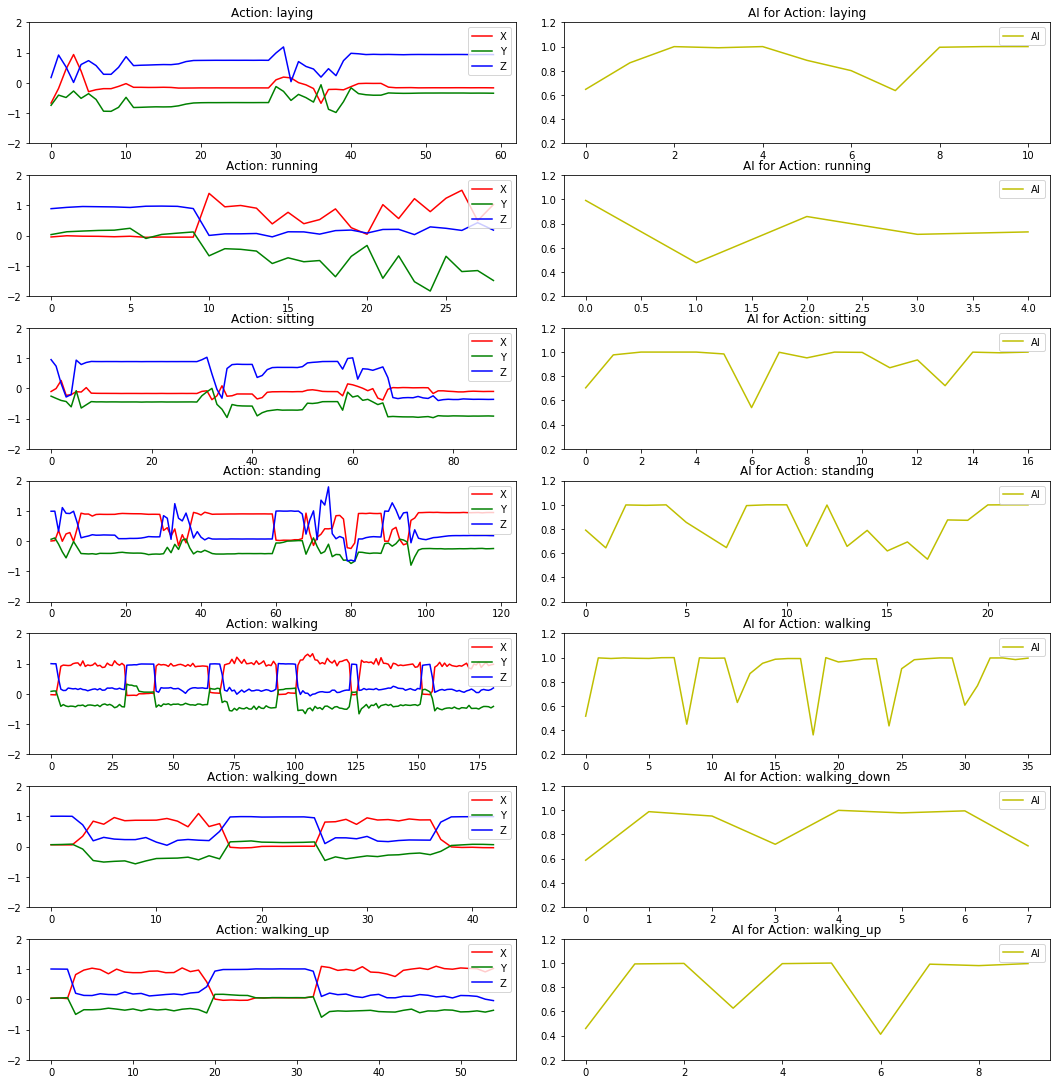

<Figure size 1152x648 with 0 Axes>

In [14]:
xyz_lb = {}

for i in range(len(label_names)):
    xyz_lb[label_names[i]] = dkey[label_names[i]].values

all_ai = []

# plot!
fig, axes = plt.subplots(nrows=len(label_names), ncols=2, figsize=(15,15))
fig.tight_layout()

for i in range(len(label_names)):
    lb = label_names[i]
    x_val = []
    y_val = []
    z_val = []
    pulse = []
    xyz_val = []
    ai_act = []
    count = 0
    H = 5     # window size
    g = 9.8
    
    for ts in xyz_lb[lb]:
        x_val.append(float(ts[0]))
        y_val.append(float(ts[1]))
        z_val.append(float(ts[2]))
        pulse.append(float(ts[3]))
        xyz_val.append([float(ts[0]),float(ts[1]),float(ts[2])])
        
    x_val = np.array(x_val)/g
    y_val = np.array(y_val)/g
    z_val = np.array(z_val)/g
    xyz_val = np.array(xyz_val)/g
    
    xyz_arr = []
    for xyz in xyz_val:
        xyz_arr.append(xyz)
        if(count==H):
            ai_val = equation_bi(xyz_arr)
#             print(ai_val)
            ai_act.append(ai_val[0])
            
            xyz_arr.clear()
            count = 0
        count+=1
        
    all_ai.append(ai_act)
    
#   plot!
    ax = axes[i,0]
    ax.plot(x_val,'r',label='X')
    ax.plot(y_val,'g',label='Y')
    ax.plot(z_val,'b',label='Z')
#     ax.plot(pulse,'y',label='pulse')
    ax.set_title('Action: ' + label_names[i])
    ax.set_ylim(bottom=-2,top=2)
    ax.legend(loc='upper right')
    

    
# print(all_ai)

for i in range(len(all_ai)):
    ax = axes[i,1]
    ax.plot(all_ai[i],'y',label='AI')
    ax.set_title('AI for Action: ' + label_names[i])
    ax.legend(loc='upper right')
    ax.set_ylim(bottom=0.2, top=1.2)

plt.figure(figsize=(16,9))
fig.savefig('fig1.png', dpi = 300)
# fig.close()

plt.show()